# Data Diri

## Name: Reza Aditya Saputra
## Domisili: Jakarta Pusat, DKI Jakarta


---



In [1]:
!wget --no-check-certificate https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip

--2021-07-08 01:38:34--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘rockpaperscissors.zip’

rockpaperscissors.z 100%[===================>] 307.92M  8.66MB/s    in 57s     

2021-07-08 01:39:32 (5.45 MB/s) - ‘rockpaperscissors.zip’ saved [322873683/322873683]



In [2]:
!rm -rf rockpaperscissors

# Extract zip files
import zipfile
local_zip = 'rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [3]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten,SpatialDropout2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.applications import MobileNetV2
import tensorflow as tf
from tensorflow.keras import optimizers


In [4]:
import os 
from os import path

base_dir = './rockpaperscissors'
train_dir = path.join(base_dir, 'rps-cv-images')
batch_size=32
target_size=(224,224)

# set train data generaor image untuk dapat diberikan label 
train_datagen = ImageDataGenerator(
  #  rescale the pixel value 1./255 from 0–255 range to 0–1 range. 
  rescale=1./255,
  #  rotate the image in range 0–20 degree.
  rotation_range=20,
  horizontal_flip=False,
  #  shear angle in counter-clockwise direction in 0.2
  height_shift_range=.2,
  validation_split=0.4,
)

train_generator = train_datagen.flow_from_directory(
  train_dir,  # direktori data latih
  target_size=target_size,  # mengubah resolusi seluruh gambar menjadi 150x150 piksel
  batch_size=batch_size,
  #  data didalam folder tersebut diacak sehingga tidak sesuai urutan yang ada seperti urutan alfabetik.
  shuffle=False,
  subset="training",
  class_mode = 'categorical')

validation_generator = train_datagen.flow_from_directory(
  train_dir, # direktori data latih
  target_size=target_size, # mengubah resolusi seluruh gambar menjadi 150x150 piksel
  batch_size=batch_size,
  shuffle=False,
  class_mode = 'categorical',
  subset="validation",)

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


## The Model

Here we setup the CNN network

In [5]:
model_base = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3))
model_base.trainable = False

model = Sequential([
  model_base,
  GlobalAveragePooling2D(),
  Dense(3, activation='softmax'),
])

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
model_viz = tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=55
)
model_viz

In [60]:
opt = optimizers.Adam()

model.compile(
    loss='categorical_crossentropy',
    # loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

In [61]:
model.build((None, 224, 224, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe multiple                  2257984   
_________________________________________________________________
module_wrapper_1 (ModuleWrap multiple                  0         
_________________________________________________________________
module_wrapper_2 (ModuleWrap multiple                  3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


## Callbacks

Here I load my Keras Callbacks to auto adjust learning rate of the training model

In [16]:
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

best_model_weights = './base.model'
checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)

tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    write_graph=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=40,
    verbose=1, 
    mode='auto',
    cooldown=1 
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

## Train The Model

Here I train our model using model.fit()

In [62]:
# Proses Training 
with tf.device("/device:GPU:0"):
  history = model.fit(
        x=train_generator,
        steps_per_epoch=50,  # berapa batch yang akan dieksekusi pada setiap epoch
        epochs=10,
        validation_data=validation_generator, # menampilkan akurasi pengujian data validasi
        validation_steps=50,
        verbose=1,
        callbacks=callbacks)

Epoch 1/10
50/50 [==============================] - 133s 3s/step - loss: 0.1278 - accuracy: 0.9564 - val_loss: 0.0612 - val_accuracy: 0.9826

Epoch 00001: val_loss did not improve from 0.03899
Epoch 2/10
50/50 [==============================] - 128s 3s/step - loss: 0.0735 - accuracy: 0.9740 - val_loss: 0.0224 - val_accuracy: 0.9916

Epoch 00002: val_loss improved from 0.03899 to 0.02239, saving model to ./base.model


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


Epoch 3/10
50/50 [==============================] - 148s 3s/step - loss: 0.0348 - accuracy: 0.9899 - val_loss: 0.0196 - val_accuracy: 0.9949

Epoch 00003: val_loss improved from 0.02239 to 0.01957, saving model to ./base.model


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


Epoch 4/10
50/50 [==============================] - 137s 3s/step - loss: 0.0143 - accuracy: 0.9979 - val_loss: 0.0182 - val_accuracy: 0.9955

Epoch 00004: val_loss improved from 0.01957 to 0.01821, saving model to ./base.model


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


Epoch 5/10
50/50 [==============================] - 128s 3s/step - loss: 0.0256 - accuracy: 0.9940 - val_loss: 0.0254 - val_accuracy: 0.9916

Epoch 00005: val_loss did not improve from 0.01821
Epoch 6/10
50/50 [==============================] - 136s 3s/step - loss: 0.0265 - accuracy: 0.9937 - val_loss: 0.0236 - val_accuracy: 0.9916

Epoch 00006: val_loss did not improve from 0.01821
Epoch 7/10
50/50 [==============================] - 148s 3s/step - loss: 0.0372 - accuracy: 0.9877 - val_loss: 0.0243 - val_accuracy: 0.9923

Epoch 00007: val_loss did not improve from 0.01821
Epoch 8/10
50/50 [==============================] - 148s 3s/step - loss: 0.0273 - accuracy: 0.9917 - val_loss: 0.0160 - val_accuracy: 0.9942

Epoch 00008: val_loss improved from 0.01821 to 0.01597, saving model to ./base.model


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


Epoch 9/10
50/50 [==============================] - 136s 3s/step - loss: 0.0202 - accuracy: 0.9942 - val_loss: 0.0232 - val_accuracy: 0.9924

Epoch 00009: val_loss did not improve from 0.01597
Epoch 10/10
50/50 [==============================] - 150s 3s/step - loss: 0.0137 - accuracy: 0.9955 - val_loss: 0.0216 - val_accuracy: 0.9942

Epoch 00010: val_loss did not improve from 0.01597


## Model Evaluation

Here I visualize the training results, load the best model weights, evalute the model, save the json file and h5 weights

In [63]:
import matplotlib.pyplot as plt

def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

# evaluate test data
def tf_data_generator(generator, input_shape):
    num_class = generator.num_classes
    tf_generator = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None
                        , input_shape[0]
                        , input_shape[1]
                        , input_shape[2]]
                       ,[None, num_class])
    )
    return tf_generator

In [34]:
#Model Evaluation

# Define Input Parameters
channel = (3, )
input_shape = target_size + channel

test_data = tf_data_generator(train_generator, input_shape)

# evaluate models
loss, acc =  model.evaluate(x=test_data,steps=len(train_generator),verbose=2)
print('Accuracy on training data: {:.4f} \nLoss on training data: {:.4f}'.format(acc,loss),'\n')

loss, acc = model.evaluate(test_data,steps=len(train_generator),verbose=0)
print('Accuracy on test data: {:.4f} \nLoss on test data: {:.4f}'.format(acc,loss),'\n')


42/42 - 57s - loss: 0.0359 - accuracy: 0.9909
Accuracy on training data: 0.9909 
Loss on training data: 0.0359 

Accuracy on test data: 0.9932 
Loss on test data: 0.0345 



10/10 [==============================] - 12s 1s/step - loss: 0.0224 - accuracy: 0.9966
Model Test Loss: 0.022411221638321877
Model Test Accuracy: 0.9966443181037903


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: my-model/assets


INFO:tensorflow:Assets written to: my-model/assets


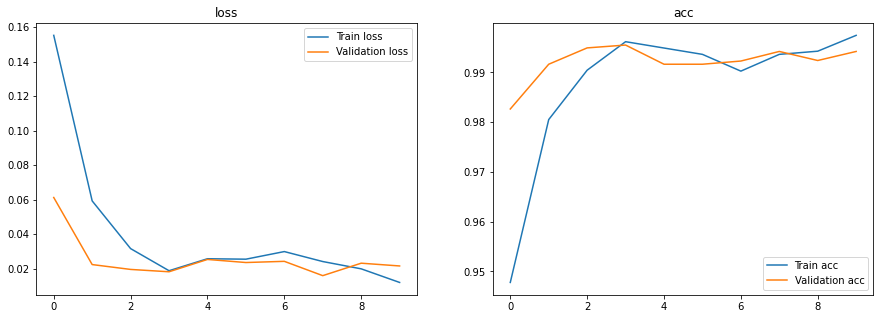

In [64]:
# Save model and load with best weight
show_final_history(history)
model.load_weights(best_model_weights)
model_score = model.evaluate(validation_generator,steps=10)
print("Model Test Loss:",model_score[0])
print("Model Test Accuracy:",model_score[1])

# save my model
model.save('my-model')

## Upload File And Predict

Saving download.jpeg to download (6).jpeg
Hasil Prediksi: Rock 0.98046553


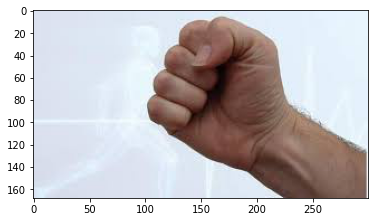

In [74]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
%matplotlib inline


def preprocess(img,input_size):
    nimg = img.convert('RGB').resize(input_size, resample= 0)
    img_arr = (np.array(nimg))/255
    return img_arr

def reshape(imgs_arr):
    return np.stack(imgs_arr, axis=0)
 
def predict(path):
  img = Image.open(path)
  X = preprocess(img, dim)
  X = reshape([X])
  y = model.predict(X)
  
  print("Hasil Prediksi:", labels[np.argmax(y)], np.max(y))
  imgplot = plt.imshow(img)



# define labels
labels = ['Paper', 'Rock', 'Scissors']
uploaded = files.upload()

for path in uploaded.keys():

  # predicting images
  predict(path)



  